# ResNet-18
Credit to: [Using ResNet for MNIST in PyTorch 1.7](https://zablo.net/blog/post/pytorch-resnet-mnist-jupyter-notebook-2021/)

##Python Setup

In [2]:
!git clone https://github.com/HanziJiang/Hahaha-Project.git

Cloning into 'Hahaha-Project'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 50 (delta 23), reused 14 (delta 6), pack-reused 0
Unpacking objects: 100% (50/50), done.


In [3]:
!pip install torch torchvision
!pip install matplotlib
!pip install import-ipynb
!pip install pytorch_extras
!pip install pytorch_lightning

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=4cdd40b4cedcf8911faef182601262039af31b0b7e8a629dedc30e1dc0f10541
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
  Created wheel for pytorch-extras: filename=pytorch_extras-0.1.3-cp37-none-any.whl size=2833 sha256=76fa1762bbbb28ce55d0f7853a89ccbd31f744ef81340db0de56904c6fe968d9
  Stored in directory: /root/.cache/pip/wheels/5b/7c/5a/f27d4088adfe722cb280d523a1ed9eeb33be11b8d3a653292a
Successfully built pytorch-extras
     |████████████████████████████████| 849kB 23.4MB/s 
     |████████████████████████████████| 184kB 53.3MB/s 
     |████████████████████████████████| 112kB 59.2MB/s 
     |████████████████████████████████| 276kB 51.2MB/s 
     |████████████████████████████████| 829kB 51.9MB/s 
     |████████████████████████████████| 1.3MB 57.2MB/s 
     |████████████████████████████████| 296kB 57.4MB/s 


In [3]:
# from google.colab import drive
# drive.mount("mnt")
# %cd "mnt/My Drive"

In [4]:
%cd "Hahaha-Project"

/content/Hahaha-Project


importing Jupyter notebook from load_DrawData_with_transform.ipynb
     |████████████████████████████████| 71kB 8.2MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.2.0-cp37-none-any.whl size=89548 sha256=04c5a92c161a9ab45dd5d11d975ce32900f64bdac5a3719f9f6e4ce56076cea5
  Stored in directory: /root/.cache/pip/wheels/40/76/48/f1effadceea83b32e7d957dd0f92db4db8b537d7b72b4ef374
Successfully built cairocffi
6000
4000
total training samples: 6000
total validatoin samples: 2000
total test samples: 2000
gs://quickdraw_dataset/full/simplified/apple.ndjson
Copying gs://quickdraw_dataset/full/simplified/apple.ndjson...
-
Operation completed over 1 objects/56.1 MiB.                                     
gs://quickdraw_dataset/full/simplified/face.ndjson
Copying gs://quickdraw_dataset/full/simplified/face.ndjson...
- [1/1 files][ 89.4 MiB/ 89.4 MiB] 100% Done                                    
Operation completed over 1 objects/89.4 MiB.                                     
adding from:  ap

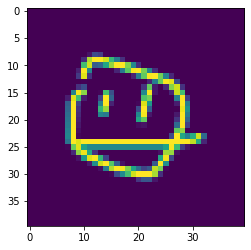

[0. 1.]
face


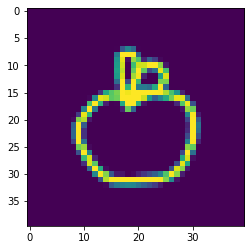

[1. 0.]
apple
2000
2000


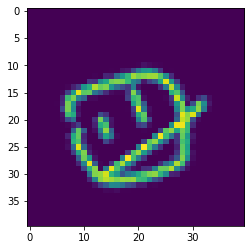

[0. 1.]
face


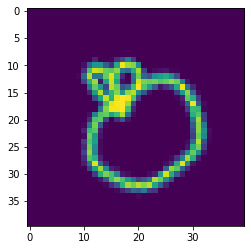

[1. 0.]
apple


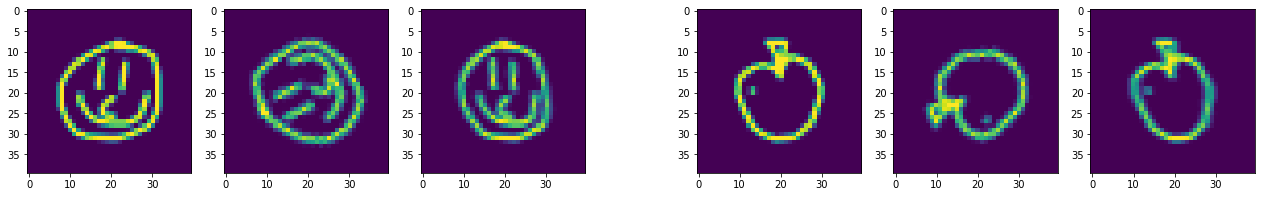

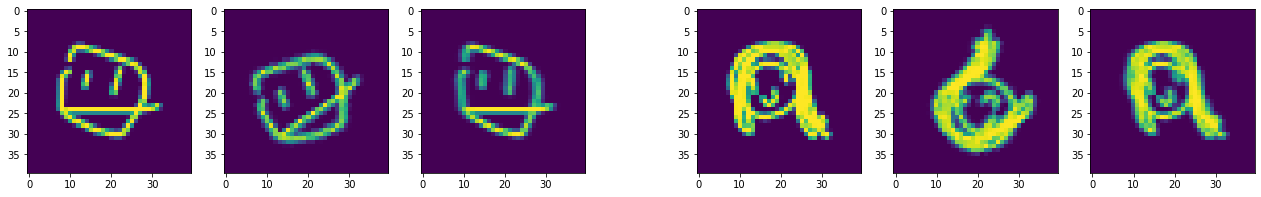

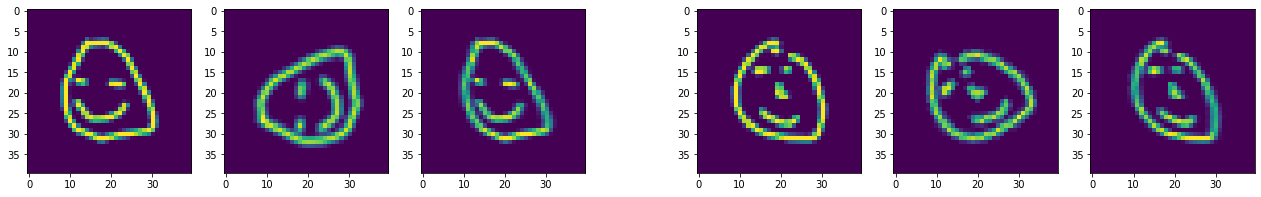

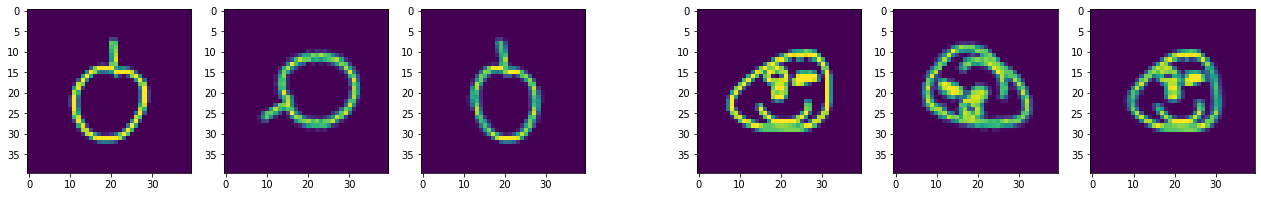

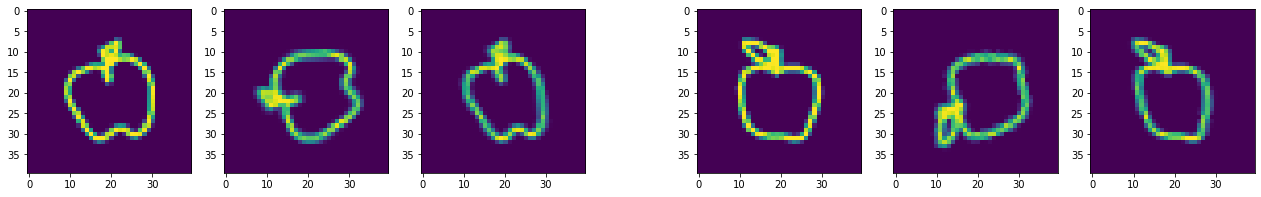

In [5]:
from torchvision.models import resnet18
from torch import nn
import torch
import numpy as np
import import_ipynb
import load_DrawData_with_transform as loader
import pytorch_lightning as pl
from pytorch_lightning.core.decorators import auto_move_data

## Model

In [26]:
class ResNet(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = resnet18()
    self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.loss = nn.CrossEntropyLoss()

  @auto_move_data
  def forward(self, x):
    x = torch.unsqueeze(x, 1)
    return self.model(x.float())
  
  def training_step(self, batch, batch_no):
    # implement single training step
    x, y = batch
    logits = self(x)
    y = y.max(1, keepdim=False)[1].type(torch.LongTensor)
    loss = self.loss(logits, y)
    return loss
  
  def configure_optimizers(self):
    return torch.optim.RMSprop(self.parameters(), lr=0.005)

## Train

In [28]:
train_loader, test_loader = loader.train_loader, loader.val_loader

model = ResNet()
model = model.cuda()

trainer = pl.Trainer(
    max_epochs=1,
    progress_bar_refresh_rate=30 # set to >= 20 if running in Google Colab
)

#model
trainer.fit(model, train_loader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.7 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.733    Total estimated model params size (MB)


1

In [29]:
trainer.save_checkpoint("resnet18_quickdraw.pt")

In [30]:
def get_prediction(x, model: pl.LightningModule):
  model.freeze() # prepares model for predicting
  probabilities = torch.softmax(model(x), dim=1)
  predicted_class = torch.argmax(probabilities, dim=1)
  return predicted_class, probabilities

In [31]:
from tqdm.autonotebook import tqdm

In [34]:
inference_model = ResNet.load_from_checkpoint("resnet18_quickdraw.pt", map_location="cuda")

In [44]:
true_y, pred_y = [], []
for batch in tqdm(iter(test_loader), total=len(test_loader)):
  x, y = batch
  y = y.max(1, keepdim=False)[1].type(torch.LongTensor)
  true_y.extend(y)
  preds, probs = get_prediction(x, inference_model)
  pred_y.extend(preds.cpu())

In [45]:
from sklearn.metrics import classification_report

In [46]:
print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.868     0.999     0.929      1005
           1      0.999     0.846     0.916       995

    accuracy                          0.923      2000
   macro avg      0.933     0.923     0.922      2000
weighted avg      0.933     0.923     0.923      2000

